# PhageHostLearn - v3.4.klebsiella - training

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. 

This notebook offers complete functionality to train a PhageHostLearn prediction model for Klebsiella phages starting from phage genomes, bacterial genomes and a matrix of known interactions.

**Overview of this notebook**
1. Initial set-up
2. Processing phage genomes and bacterial genomes into RBPs and K-locus proteins, respectively
3. Computing feature representations based on ESM-2 and Hyperdimensional computing
4. Training and evaluating the machine learning models

**Architecture of the PhageHostLearn framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Embeddings for both based on ESM-2 language models and HDC
- Combined XGBoost model (for language embeddings) and Random Forest (for HDC embeddings) to make predictions


## 1. Initial set-up

PhageHostLearn takes as inputs phage genomes and bacterial genomes that are later transformed into phage RBPs and bacterial K-locus proteins. To do this data processing, you'll need to do the following:
1. Set up a folder for all the data that will be stored and generated by PhageHostLearn. Write the path to this folder in the code block below for 'general_path'.
2. In the folder, create two subfolders for the phage genomes and bacterial genomes (one for phage genomes and one for bacterial genomes). Collect both phage genomes and bacterial genomes as individual FASTA files and store them in the two separate folders.
3. Install [PHANOTATE](https://github.com/deprekate/PHANOTATE) and [Kaptive](https://github.com/katholt/Kaptive), both of which you'll need to process the phage and bacterial genomes. Locate PHANOTATE and write the path under the 2.1 code block below. **(Can be simplified by copying PHANOTATE into code folder.)** From the Kaptive repository, copy the .gbk databases into the general data folder.
4. Optionally install [bio_embeddings](https://github.com/sacdallago/bio_embeddings) to locally compute protein embeddings needed for RBP detection or opt do do this step in the cloud for faster results (see instructions below).
5. Install [fair-esm](https://github.com/facebookresearch/esm) to compute ESM-2 embeddings for the PhageHostLearn interaction prediction models.
6. Install [Julia](https://julialang.org) to compute hyperdimensional embeddings for the PhageHostLearn interaction prediction models. **extra info on packages etc...**
7. Store the known interactions between phages and bacteria in an .xlsx file in which the first column is used for bacterial genome names and the first row is used for phage genome names. The names should correspond to the FASTA files in the respective folders.

In [1]:
general_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
data_suffix = 'Valencia'

## 2. Data processing

The data processing of PhageHostLearn consists of five consecutive steps: (1) phage gene calling with PHANOTATE, (2) phage protein embedding with bio_embeddings, (3) phage RBP detection, (4) bacterial genome processing with Kaptive and (5) processing the interaction matrix.

In [2]:
import phagehostlearn_processing as phlp

#### 2.1 PHANOTATE

In [ ]:
phage_genomes_path = general_path+'/phages_genomes'
phanotate_path = '/opt/homebrew/Caskroom/miniforge/base/envs/ML1/bin/phanotate.py'
phlp.phanotate_processing(general_path, phage_genomes_path, phanotate_path, data_suffix=data_suffix)

#### 2.2 Protein embeddings

The code block below computes protein embeddings for all of the detected phage genes (translated to proteins) using the bio_embeddings package (see Initial set-up). This might take a while on CPU. Alternatively, you can run this step in Google Colab or on Kaggle using the 'compute_embeddings_cloud.ipynb', which does exactly the same thing.

In [ ]:
phlp.compute_protein_embeddings(general_path, data_suffix=data_suffix)

#### 2.3 PhageRBPdetect

Either copy the `RBPdetect_phageRBPs.hmm` and `RBPdetect_xgb_hmm.json` files into the general data folder, or provide their absolute paths in the code block below.

In [ ]:
pfam_path = general_path+'/RBPdetect_phageRBPs.hmm'
hmmer_path = '/Users/Dimi/hmmer-3.3.1'
xgb_path = general_path+'/RBPdetect_xgb_hmm.json'
gene_embeddings_path = general_path+'/phage_protein_embeddings'+data_suffix+'.csv'
phlp.phageRBPdetect(general_path, pfam_path, hmmer_path, xgb_path, gene_embeddings_path, data_suffix=data_suffix)

#### 2.4 Kaptive

In [4]:
bact_genomes_path = general_path+'/klebsiella_genomes/fasta_files'
kaptive_database_path = general_path+'/Klebsiella_k_locus_primary_reference.gbk'
phlp.process_bacterial_genomes(general_path, bact_genomes_path, kaptive_database_path, data_suffix=data_suffix)

  0%|          | 0/200 [00:00<?, ?it/s]

#### 2.5 Process the interaction matrix

In [35]:
interactions_xlsx_path = general_path+'/klebsiella_phage_host_interactions.xlsx'
phlp.process_interactions(general_path, interactions_xlsx_path, data_suffix=data_suffix)

In [36]:
output = general_path+'/phage_host_interactions'+data_suffix
new_file = general_path+'/klebsiella_interactions_part2.xlsx' # part 2
phlp.add_to_database(output+'.csv', new_file, output)

## 3. Feature construction

Starts from the RBPbase.csv and the Locibase.json in the general_path. The last function outputs two feature matrices (ESM-2 and HDC), labels, groups_loci and groups_phage (for evaluation). If the ESM-2 embeddings take too long, you might opt to do this step in the cloud or on a high-performance computer.

If you're retraining a model with the same data but new validated interactions, you can simply run the `construct_feature_matrices` function to construct updated feature matrices and labels and train models anew. If you've also added new phage or bacterial genomes, you need to rerun all of the processing steps as well (only for the new data **work in progress**).

In [2]:
import phagehostlearn_features as phlf

In [ ]:
phlf.compute_esm2_embeddings_rbp(general_path, data_suffix=data_suffix)

In [7]:
phlf.compute_esm2_embeddings_loci(general_path, data_suffix=data_suffix)


 96%|█████████████████████████████████████▋ | 193/200 [2:13:34<04:11, 35.90s/it]


100%|███████████████████████████████████████| 200/200 [2:17:00<00:00, 41.10s/it]


In [15]:
locibase_path = general_path+'/Locibase'+data_suffix+'.json'
rbpbase_path = general_path+'/RBPbase'+data_suffix+'.csv'
phlf.compute_hdc_embedding(general_path, data_suffix, locibase_path, rbpbase_path, mode='train')

b'WARNING: using LinearAlgebra.normalize! in module HyperdimensionalComputing conflicts with an existing identifier.\nLoading data...\nComputing loci representations...\nComputing RBP representations...\nDone!\n'


In [3]:
rbp_embeddings_path = general_path+'/esm2_embeddings_rbp'+data_suffix+'.csv'
loci_embeddings_path = general_path+'/esm2_embeddings_loci'+data_suffix+'.csv'
hdc_embeddings_path = general_path+'/hdc_features'+data_suffix+'.txt'

In [4]:
features_esm2, features_hdc, labels, groups_loci, groups_phage = phlf.construct_feature_matrices(general_path, 
                                                                            data_suffix, loci_embeddings_path, 
                                                                            rbp_embeddings_path, hdc_embeddings_path)

Dimensions match? True
Dimensions match? True


## 4. Training and evaluating models

In [5]:
import math
import random
import pickle
import subprocess
import numpy as np
import pandas as pd
import phagehostlearn_utils as phlu
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import dump, load
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
%matplotlib inline

In [6]:
results_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'

#### 4.1 Training both models and saving them for later use

In [12]:
cpus=6
labels = np.asarray(labels)

In [13]:
# ESM-2 FEATURES + XGBoost model
imbalance = sum([1 for i in labels if i==1]) / sum([1 for i in labels if i==0])
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                    n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
xgb.fit(features_esm2, labels)
xgb.save_model('phagehostlearn_esm2_xgb.json')

In [14]:
# HDC FEATURES + RF model
rf = RandomForestClassifier(n_estimators=1250, max_depth=3, class_weight='balanced', n_jobs=cpus)
rf.fit(features_hdc, labels)
dump(rf, 'phagehostlearn_hdc_rf.joblib') 

['phagehostlearn_hdc_rf_v34all.joblib']

#### 4.2 LOGOCV with the combined model

In [13]:
logo = LeaveOneGroupOut()
cpus = 6
scores_lan = []
scores_hdc = []
label_list = []
labels = np.asarray(labels)
pbar = tqdm(total=len(set(groups_loci)))
for train_index, test_index in logo.split(features_esm2, labels, groups_loci):
    # get the training and test data
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    Xhdc_train, Xhdc_test = features_hdc[train_index], features_hdc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i==1]) / sum([1 for i in y_train if i==0])

    ## ESM-2 EMBEDDINGS: XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    
    ## HDC EMBEDDINGS: RF model
    rf = RandomForestClassifier(n_estimators=1250, max_depth=3, class_weight='balanced', n_jobs=cpus)
    rf.fit(Xhdc_train, y_train)
    score_rf = rf.predict_proba(Xhdc_test)[:,1]
    scores_hdc.append(score_rf)
    
    # save labels for later
    label_list.append(y_test)
    
    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
# save results
logo_results = {'labels': label_list, 'scores_language': scores_lan, 'scores_hdc': scores_hdc}   
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'wb') as f:
    pickle.dump(logo_results, f)

In [7]:
# read results
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
scores_hdc = logo_results['scores_hdc']
label_list = logo_results['labels']

# compute performance
rocaucs = []
praucs = []
rqueries_lan = []
rqueries_hdc = []
rqueries_ens = []
random_guess = []
for i in range(len(set(groups_loci))):
    score_lan = scores_lan[i]
    score_hdc = scores_hdc[i]
    score_ens = [phlu.uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
    y_test = label_list[i]
    try:
            roc_auc = roc_auc_score(y_test, score_ens)
            rocaucs.append(roc_auc)
            precision, recall, thresholds = precision_recall_curve(y_test, score_ens)
            praucs.append(round(auc(recall, precision), 3))
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            ranked_hdc = [x for _, x in sorted(zip(score_hdc, y_test), reverse=True)]
            ranked_ens = [x for _, x in sorted(zip(score_ens, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            rqueries_hdc.append(ranked_hdc)
            rqueries_ens.append(ranked_ens)
            random_guess.append(random.sample(ranked_ens, len(ranked_ens)))
    except:
        pass

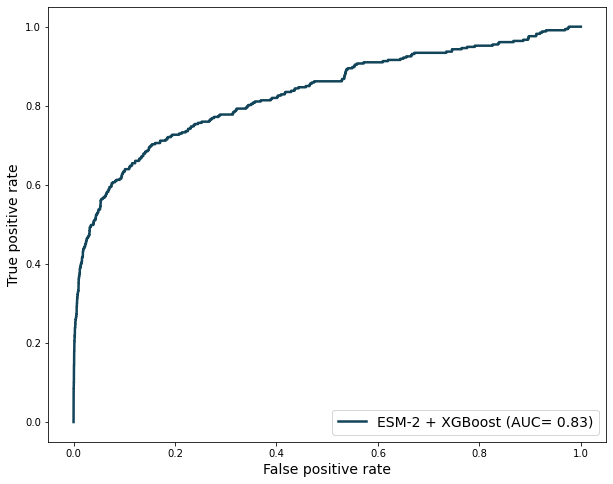

In [8]:
# results, ROC AUC
scores_ens = []
for i in range(len(set(groups_loci))):
    score_lan = scores_lan[i]
    score_hdc = scores_hdc[i]
    score_ens = [phlu.uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
    scores_ens.append(score_ens)
    
labels = np.concatenate(label_list).ravel()
scoreslr = np.concatenate(scores_lan).ravel()
scoreshr = np.concatenate(scores_hdc).ravel()
scoreser = np.concatenate(scores_ens).ravel()

fig, ax = plt.subplots(figsize=(10,8))
fpr, tpr, thrs = roc_curve(labels, scoreslr)
rauclr = round(auc(fpr, tpr), 3)
ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost (AUC= '+str(rauclr)+')')
#fpr, tpr, thrs = roc_curve(labels, scoreshr)
#rauchr = round(auc(fpr, tpr), 3)
#ax.plot(fpr, tpr, c='#E15554', linewidth=2.5, ls='-.', label='HDC + Random Forest (AUC= '+str(rauchr)+')')
#fpr, tpr, thrs = roc_curve(labels, scoreser)
#raucer = round(auc(fpr, tpr), 3)
#ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='Combined model (AUC= '+str(raucer)+')')
ax.set_xlabel('False positive rate', size=14)
ax.set_ylabel('True positive rate', size=14)
ax.legend(loc=4, prop={'size': 14})
fig.savefig(results_path+'/v3.4/logocv_rocauc.png', dpi=400)
fig.savefig(results_path+'/v3.4/logocv_rocauc_svg.svg', format='svg', dpi=400)

In [42]:
# Look at performance per serotype
seros = pd.read_csv(general_path+'/serotypesValencia.csv')

In [97]:
# read results
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
scores_hdc = logo_results['scores_hdc']
label_list = logo_results['labels']

unique_seros = list(set(seros['sero']))
performance_ktypes = {}
for unique in unique_seros:
    indices = seros['sero'] == unique
    subscores_lan = [val for is_good, val in zip(indices, scores_lan) if is_good]
    subscores_hdc = [val for is_good, val in zip(indices, scores_hdc) if is_good]
    sublabels = [val for is_good, val in zip(indices, label_list) if is_good]
    rqueries_lan = []
    rqueries_hdc = []
    rqueries_ens = []
    for i in range(len(subscores_lan)):
        score_lan = subscores_lan[i]
        score_hdc = subscores_hdc[i]
        score_ens = [phlu.uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
        y_test = sublabels[i]
        if sum(y_test) > 0:
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            ranked_hdc = [x for _, x in sorted(zip(score_hdc, y_test), reverse=True)]
            ranked_ens = [x for _, x in sorted(zip(score_ens, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            rqueries_hdc.append(ranked_hdc)
            rqueries_ens.append(ranked_ens)
    if len(rqueries_lan) > 0:
        mar_lan = round(phlu.marecallatk(rqueries_lan, 50), 3)
        mar_hdc = round(phlu.marecallatk(rqueries_hdc, 50), 3)
        mar_ens = round(phlu.marecallatk(rqueries_ens, 50), 3)
        performance_ktypes[unique] = [('MAR_XGB', mar_lan), ('MAR_HDC', mar_hdc), ('MAR_COMBINED', mar_ens)]
    #else:
    #    performance_ktypes[unique] = [('MAR_XGB', np.nan), ('MAR_HDC', np.nan), ('MAR_COMBINED', np.nan)]

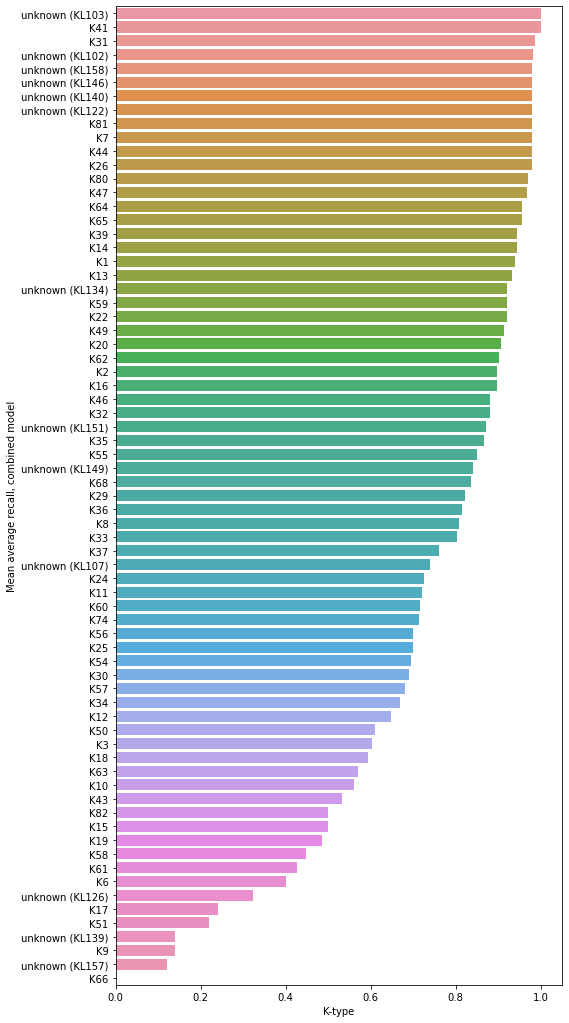

In [103]:
import seaborn as sns
performance_mar_combined = []
for ktype in performance_ktypes:
    performance_mar_combined.append(performance_ktypes[ktype][2][1])
sortedpairs = [(x,y) for y, x in sorted(zip(performance_mar_combined, list(performance_ktypes.keys())), reverse=True)]
fig, ax = plt.subplots(figsize=(8,18))
sns.barplot(x=[score for (key, score) in sortedpairs], y=[key for (key, score) in sortedpairs], ax=ax)
ax.set_xlabel('K-type')
ax.set_ylabel('Mean average recall, combined model')
plt.show()

#### Comparing ML hit ratio with what we would do as microbiologist

In [9]:
import pandas as pd
import numpy as np
import json
import random

# prep the data
interactions1 = general_path+'/klebsiella_phage_host_interactions.xlsx'
interactions2 = general_path+'/klebsiella_interactions_part2.xlsx' # for part 1 NO SUGGESTIONS POSSIBLE -> ALL UNIQUE K-TYPES
matrix1 = pd.read_excel(interactions1, index_col=0, header=0)
matrix2 = pd.read_excel(interactions2, index_col=0, header=0)
locipath = general_path+'/LocibaseValencia.json'
seros = pd.read_csv(general_path+'/serotypesValencia.csv')
with open(locipath) as f:
    locibase = json.load(f)

# do the informed approach
hits = {i: 0 for i in range(1, 51)}
total = 0
# --------------------
# MATRIX 1
# --------------------
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]
    
# phages sorted by broad-spec
sorted_phages = matrix1.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix1.index.values)
no_genome = ['K2', 'K21', 'K23', 'K27', 'K28', 'K40', 'K45', 'K48', 'K52', 'K53', 'K67', 'K69', 'K70', 'K71', 'K72']
rownames = [str(i) for i in rownames if i not in no_genome]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]
        
# iterate over all accessions in matrix1
for i, accession in enumerate(rownames):
    # only compute hit ratio when we can find something
    if sum(matrix1.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix1 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix1.columns[matrix1.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix1[x].sum(), reverse=True)
        
        total += 1
        for k in range(1, 51):
            # approach 1: if we dont have enough suggestions, pick extra at random from total pool available
            # approach 2: now, we supplement them with the sorted phages by broad-spectrum, not random!
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]

            #suggested = random.sample(phage_suggestions, k)
            if any([matrix1.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                
# --------------------
# MATRIX 2
# --------------------
hits2 = {i: 0 for i in range(1, 51)}
total2 = 0
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]
    
sorted_phages = matrix2.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix2.index.values)
rownames = [str(i) for i in rownames]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]

# iterate over all accessions in matrix2
for i, accession in enumerate(matrix2.index.values):
    # only compute hit ratio when we can find something
    if sum(matrix2.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix2 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix2.columns[matrix2.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix2[x].sum(), reverse=True)

        total += 1
        total2 += 1
        for k in range(1, 51):
            # if we dont have enough suggestions, pick extra at random from the total pool
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]
            
            if any([matrix2.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                hits2[k] += 1

informed_hitratio = {k: v/total for k, v in hits.items()}
informed_hitratio2 = {k: v/total2 for k, v in hits2.items()}

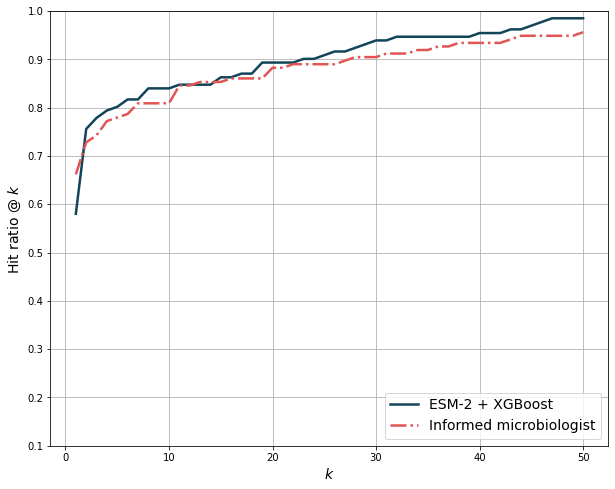

In [10]:
# results, hit ratios @ K
ks = np.linspace(1, 50, 50)
hits_lan = [phlu.hitratio(rqueries_lan, int(k)) for k in ks]
hits_hdc = [phlu.hitratio(rqueries_hdc, int(k)) for k in ks]
hits_ens = [phlu.hitratio(rqueries_ens, int(k)) for k in ks]
hits_random = [phlu.hitratio(random_guess, int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ks, hits_lan, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost')
#ax.plot(ks, hits_hdc, c='#E15554', linewidth=2.5, ls='-.', label='HDC + Random Forest')
#ax.plot(ks, hits_ens, c='#124559', linewidth=2.5, label='Combined model')
#ax.plot(ks, hits_random, c='#81B29A', linewidth=2.5, ls=':', label='Random guess')
ax.plot(ks, list(informed_hitratio.values()), c='#E15554', linewidth=2.5, ls='-.', label='Informed microbiologist')
#ax.plot(ks, list(informed_hitratio2.values()), c='#E15554', linewidth=2.5, ls=':', label='Informed guess (Bea only)')
ax.set_xlabel('$\it{k}$', size=14)
ax.set_ylabel('Hit ratio @ $\it{k}$', size=14)
ax.set_ylim(0.1, 1)
ax.legend(loc=4, prop={'size': 14})
ax.grid(True)
fig.savefig(results_path+'/v3.4/logocv_hitratio_informed.png', dpi=400)
fig.savefig(results_path+'/v3.4/logocv_hitratio_informed_svg.svg', format='svg', dpi=400)

## 5. Active learning

1. Randomly select 10% of bacteria for testing
2. Use the other 90% to progressively train HDC model (iteratively increasing training size)
3. Compute the top 1, 3, 5 hit ratio on the  held-out test set
4. Repeat the process 100 times

In [131]:
repeats = 100
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight='balanced', n_jobs=cpus)
labels = np.asarray(labels)
pbar = tqdm(total=repeats)
hits_1d = {}
hits_3d = {}
hits_5d = {}
cpus = 6

for rep in range(repeats):
    # 1. Randomly select 10% of groups for testing
    hits_1d[rep] = []; hits_3d[rep] = []; hits_5d[rep] = []
    gss = GroupShuffleSplit(n_splits=1, train_size=.9)
    for (train_index, test_index) in gss.split(features_hdc, labels, groups_loci):
        X_train, X_test = features_hdc[train_index], features_hdc[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        groups_train = np.asarray(groups_loci)[train_index]
        groups_test = np.asarray(groups_loci)[test_index]

        # 2. Progressively train on the 90% (thus we select the TEST set below)
        group_kfold = GroupKFold(n_splits=9)
        progressive_index = []
        for (train_k, test_k) in group_kfold.split(X_train, y_train, groups_train):
            progressive_index.append(test_k)
            progressive_indices = np.concatenate((progressive_index))
            X_train_progressive = X_train[progressive_indices]
            y_train_progressive = y_train[progressive_indices]

            # HDC RF model
            rf.fit(X_train_progressive, y_train_progressive)

            # 3. Compute the top 1, 3, 5 hit ratio on the held-out test set
            scores = rf.predict_proba(X_test)[:,1]
            rqueries = []
            # account for multiple bacteria in test set by looping over each one
            for testgroup in set(groups_test):
                group_scores = scores[groups_test == testgroup]
                group_y = y_test[groups_test == testgroup]
                # only add query if there's actually a positive to find
                if sum(group_y) > 0:
                    ranked_query = [x for _, x in sorted(zip(group_scores, group_y), reverse=True)]
                    rqueries.append(ranked_query)
            hits_1d[rep].append(hitratio(rqueries, 1))
            hits_3d[rep].append(hitratio(rqueries, 3))
            hits_5d[rep].append(hitratio(rqueries, 5))

    # pbar update
    pbar.update(1)

pbar.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [133]:
hitratio_1 = []; hitratio_3 = []; hitratio_5 = []
for i in range(9):
    hrs_1 = [hits_1d[key][i] for key in hits_1d.keys()]
    hrs_3 = [hits_3d[key][i] for key in hits_3d.keys()]
    hrs_5 = [hits_5d[key][i] for key in hits_5d.keys()]
    hitratio_1.append(np.mean(hrs_1))
    hitratio_3.append(np.mean(hrs_3))
    hitratio_5.append(np.mean(hrs_5))

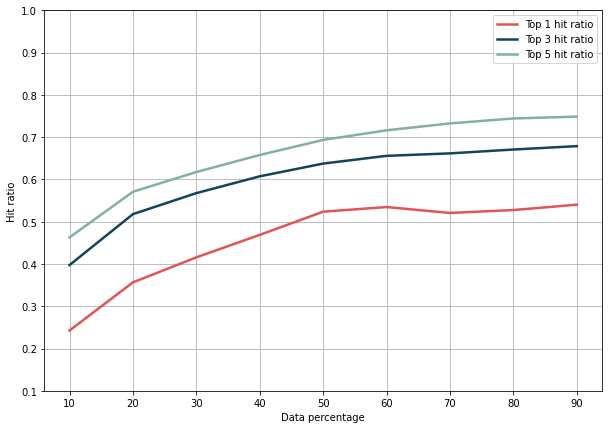

In [136]:
fig, ax = plt.subplots(figsize=(10,7))
percentage = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ax.plot(percentage, hitratio_1, c='#E15554', linewidth=2.5, label='Top 1 hit ratio')
ax.plot(percentage, hitratio_3, c='#124559', linewidth=2.5, label='Top 3 hit ratio')
ax.plot(percentage, hitratio_5, c='#81B29A', linewidth=2.5, label='Top 5 hit ratio')
ax.set_xlabel('Data percentage')
ax.set_ylabel('Hit ratio')
ax.set_ylim(0.1, 1)
ax.legend()
ax.grid(True)
fig.savefig(results_dir+'/v3.2/hdc_convolved_activelearning_groupshuffle.png', dpi=400)
fig.savefig(results_dir+'/v3.2/hdc_convolved_activelearning_groupshuffle_svg.svg', format='svg', dpi=400)